# Written Exercise 12.

Choose an attacker and their effective parameters. Choose a defense. Compare the resistance impaired by the defense and reduced accuracy on the dataset used in the deference vs. a separate dataset not used in
the defense. That is, you will need to inspect attacker effectiveness and model performance on two different subsets, one of them used for defense, and the other not, both before and after defense. What do the results imply about the effectiveness of the defense in the real world?

### Import Homeworks and Functions

In [1]:
%matplotlib agg
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from tqdm.notebook import tqdm

from IPython.display import clear_output

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import gridspec

import hw4_utils
import hw4_mnist

# nicer color map for visualizing both positive and negative attributions
hot = cm.get_cmap('hot', 128)
cool = cm.get_cmap('cool', 128)
binary = cm.get_cmap('binary', 128)
hotcold = np.vstack((binary(np.linspace(0,1,128)) * cool(np.linspace(0, 1, 128)),
                     hot(np.linspace(0, 1, 128))))
hotcold_cmap = ListedColormap(hotcold, name='hotcold')

# for latex in matplotlib:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

import hw4_part1
import hw4_part2


def show_attack(attacker, idxs, dat):  
    X = dat.X[idxs]
    Y = dat.Y[idxs]
    
    Xp = att.attack_batch(X, Y)

    for x, xp, yt, idx in list(zip(X, Xp, Y, idxs)):    
        y  = np.argmax(m.model.predict(x [np.newaxis, :, :, :])[0])
        yp = np.argmax(m.model.predict(xp[np.newaxis, :, :, :])[0])
    
        d = (x-xp).flatten()

        dnorms, dnorms_str = hw4_utils.norms(np.expand_dims(d, axis=0))
    
        lim = max(abs(np.min(d)), abs(np.max(d)))
        # make colorbar limits symmetric, with black being 0
    
        print(f"{yt}: {y} -> {yp} {dnorms_str}")

        fig = plt.figure(figsize=(6.5,3))
        gs = gridspec.GridSpec(1,3, width_ratios=[2,2,2])
        axs = [plt.subplot(gs[i]) for i in range(3)]
    
        fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0)
    
        axs[0].set_axis_off()
        axs[1].set_axis_off()
        axs[2].set_axis_off()
    
        axs[0].imshow(x[:,:,0])
        axs[1].imshow(xp[:,:,0])
        c = axs[2].imshow((xp-x)[:,:,0], cmap=hotcold_cmap, vmin=-lim, vmax=lim)
        
        cax = fig.add_axes([axs[2].get_position().x1+0.01,
                            axs[2].get_position().y0,
                            0.1,
                            axs[2].get_position().y1 - axs[2].get_position().y0])
        
        fig.colorbar(mappable=c, cax=cax)
        
        fig.suptitle(f"instance={idx}, {y} $\\rightarrow$ {yp}, {dnorms_str}\n{str(att)}")
    
        display(fig)
        
    plt.close('all')

### Load Model and Data

In [2]:
# Load original Model
m = hw4_mnist.MNISTModel()
m.load()

# Load Data
mnist_data = hw4_mnist.load_data()
train_X = mnist_data.train.X
train_Y = mnist_data.train.Y

test_X2 = mnist_data.test.X[:4800]
test_Y2 = mnist_data.test.Y[:4800]

test_X1 = mnist_data.test.X[4800:9600]
test_Y1 = mnist_data.test.Y[4800:9600]

### Run Test data for original accuracy 

In [3]:
print("Original Accuracy on Test Group 1:")
m_acc = m.model.evaluate(test_X1,test_Y1)

print("\nOriginal Accuracy on Test Group 2:")
m_acc = m.model.evaluate(test_X2,test_Y2)

Original Accuracy on Test Group 1:
4800/4800 [==============================] - 0s 84us/sample - loss: 0.0349 - acc: 0.9892

Original Accuracy on Test Group 2:
4800/4800 [==============================] - 0s 54us/sample - loss: 0.0968 - acc: 0.9696


### Attack Model with CLW2

In [6]:
"""
# CWL2 on M1
att = hw4_part1.CWL2Attacker(
        model=m,
        num_steps=10,
        target=None,
        learning_rate=1.0,
        learning_rate_decay=0.9,
        k=0,
        c=4
    )

att_X1 = att.attack(test_X1,test_Y1)
att_X2 = att.attack(test_X2,test_Y2)
"""
# augented fine tune
print("Original Attack Set 1")
m.model.evaluate(att_X1,test_Y1)

print("\nOriginal Attack Set 2")
m.model.evaluate(att_X2,test_Y2)

Original Attack Set 1
4800/4800 [==============================] - 0s 59us/sample - loss: 0.8722 - acc: 0.2379

Original Attack Set 2
4800/4800 [==============================] - 0s 60us/sample - loss: 0.9682 - acc: 0.1988


[0.9681626772880554, 0.19875]

### Make Defense

In [7]:
import copy
PM_finetune = hw4_part2.PreMadryDefender(finetune = True, attacker = att, model = copy.copy(m))
PM_ft_XY = PM_finetune.defend(test_X1,test_Y1)

defense training:   0%|          | 0/300 [00:00<?, ?batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:   0%|          | 1/300 [00:00<02:24,  2.07batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:   1%|          | 2/300 [00:00<01:50,  2.70batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:   1%|▏         | 4/300 [00:00<01:25,  3.47batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:   2%|▏         | 5/300 [00:00<01:08,  4.31batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

   

defense training:  14%|█▍        | 42/300 [00:05<00:29,  8.64batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  14%|█▍        | 43/300 [00:05<00:29,  8.65batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  15%|█▌        | 45/300 [00:05<00:27,  9.27batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  15%|█▌        | 46/300 [00:05<00:28,  8.89batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  16%|█▌        | 47/300 [00:05<00:28,  8.96batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, 

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  30%|███       | 90/300 [00:09<00:20, 10.16batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  31%|███       | 92/300 [00:09<00:20, 10.19batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  31%|███▏      | 94/300 [00:10<00:19, 10.48batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                 

defense training:  46%|████▌     | 137/300 [00:14<00:17,  9.54batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  46%|████▋     | 139/300 [00:14<00:16,  9.83batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  47%|████▋     | 141/300 [00:14<00:15, 10.02batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  48%|████▊     | 143/300 [00:15<00:15,  9.97batches/s]


                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  62%|██████▏   | 185/300 [00:19<00:11,  9.99batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  62%|██████▏   | 187/300 [00:19<00:11,  9.87batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  63%|██████▎   | 189/300 [00:19<00:11,  9.96batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batc

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  77%|███████▋  | 231/300 [00:23<00:06, 10.00batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  78%|███████▊  | 233/300 [00:24<00:06,  9.91batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  78%|███████▊  | 234/300 [00:24<00:06,  9.88batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  78%|███████▊  | 235/300 [00:24<00:06,  9.91batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]



defense training:  91%|█████████▏| 274/300 [00:28<00:02,  9.67batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  92%|█████████▏| 276/300 [00:28<00:02, 10.01batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  93%|█████████▎| 278/300 [00:28<00:02, 10.03batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  93%|█████████▎| 280/300 [00:28<00:01, 10.01batches/s]


                                                         
defense training:   7%|▋         | 20/300 [00:02<00:30,  9.30batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:   7%|▋         | 21/300 [00:02<00:29,  9.31batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:   8%|▊         | 23/300 [00:02<00:29,  9.40batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:   8%|▊         | 24/300 [00:02<00:29,  9.49batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:   8%|▊         | 25/300 [00:02<00:29,  9.44bat

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  21%|██        | 62/300 [00:06<00:25,  9.49batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  21%|██        | 63/300 [00:06<00:26,  9.11batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  21%|██▏       | 64/300 [00:06<00:26,  8.93batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  22%|██▏       | 65/300 [00:06<00:27,  8.68batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  22%|██▏       | 66/300 [00:06<00:26,  8.94batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?

defense training:  34%|███▍      | 102/300 [00:10<00:21,  9.07batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  34%|███▍      | 103/300 [00:10<00:21,  9.11batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  35%|███▌      | 105/300 [00:11<00:20,  9.40batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  35%|███▌      | 106/300 [00:11<00:21,  9.21batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  36%|███▌      | 107/300 [00:11<00:21,  9.08batches/s]

attacking batch:   0%|          | 0/10 [00:0

                                                         
defense training:  48%|████▊     | 144/300 [00:15<00:17,  9.17batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  48%|████▊     | 145/300 [00:15<00:16,  9.36batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  49%|████▊     | 146/300 [00:15<00:16,  9.39batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  49%|████▉     | 147/300 [00:15<00:16,  9.04batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  49%|████▉     | 148/300 [00:15<00:16,  9.05batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                             

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  62%|██████▏   | 185/300 [00:19<00:12,  8.97batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  62%|██████▏   | 186/300 [00:19<00:12,  8.86batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  62%|██████▏   | 187/300 [00:20<00:12,  9.11batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  63%|██████▎   | 188/300 [00:20<00:12,  9.22batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  63%|██████▎   | 189/300 [00:20<00:12,  9.11batches/s]

attacking batch:   0%|          | 0/10 [00:00

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  75%|███████▌  | 225/300 [00:24<00:08,  8.86batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  75%|███████▌  | 226/300 [00:24<00:08,  8.88batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  76%|███████▌  | 227/300 [00:24<00:08,  8.93batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  76%|███████▌  | 228/300 [00:24<00:08,  8.96batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  76%|███████▋  | 229/300 [00:24<00:07,  9.09batches/s]

attacking batch:   0%|          | 0/10 [00:00

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  88%|████████▊ | 265/300 [00:28<00:03,  8.85batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  89%|████████▊ | 266/300 [00:28<00:03,  8.60batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  89%|████████▉ | 267/300 [00:29<00:03,  8.61batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  89%|████████▉ | 268/300 [00:29<00:03,  8.50batches/s]

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]

                                                         
defense training:  90%|████████▉ | 269/300 [00:29<00:03,  8.64batches/s]

attacking batch:   0%|          | 0/10 [00:00

### Attack with Defended Sub Sample and New Sample

In [8]:
# CWL2 on M1
att2 = hw4_part1.CWL2Attacker(
        model=PM_finetune.model,
        num_steps=10,
        target=None,
        learning_rate=1.0,
        learning_rate_decay=0.9,
        k=0,
        c=4
    )

att_X1 = att2.attack(test_X1,test_Y1)


# augented fine tune
print("Pre Madry Fine Tune On Sample 1:")
PM_finetune.model.model.evaluate(att_X1,test_Y1)

attacking:  22%|██▏       | 65/300 [00:07<00:27,  8.50batch/s]


attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]
                                                         
attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]
                                                         
attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]
                                                         
attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]
                                                         
attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]


attacking:  65%|██████▌   | 196/300 [00:22<00:11,  8.86batch/s]


attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]


attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]
                                                               

Pre Madry Fine Tune On Sample 1:
  32/4800 [..............................] - ETA: 0s - loss: 1.1326 - acc: 0.2812

4800/4800 [==============================] - 0s 56us/sample - loss: 0.7674 - acc: 0.4308


[0.76735089580218, 0.43083334]

In [9]:
att_X2 = att2.attack(test_X2,test_Y2)

# augented fine tune
print("Pre Madry Fine Tune On Sample 2:")
PM_finetune.model.model.evaluate(att_X2,test_Y2)

attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]


attacking:  44%|████▎     | 131/300 [00:15<00:19,  8.56batch/s]


attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]


attacking:  87%|████████▋ | 262/300 [00:31<00:04,  8.18batch/s]


attacking batch:   0%|          | 0/10 [00:00<?, ?step/s]
                                                               

Pre Madry Fine Tune On Sample 2:
  32/4800 [..............................] - ETA: 0s - loss: 0.6720 - acc: 0.4375

4800/4800 [==============================] - 0s 56us/sample - loss: 1.0239 - acc: 0.3277


[1.0238600448767343, 0.32770833]

### Show distortions for each attack

Original Attack
7: 7 -> 7 $L_0$=784.0000, $L_1$=53.5533, $L_2$=4.3669, $L_\infty$=0.9675


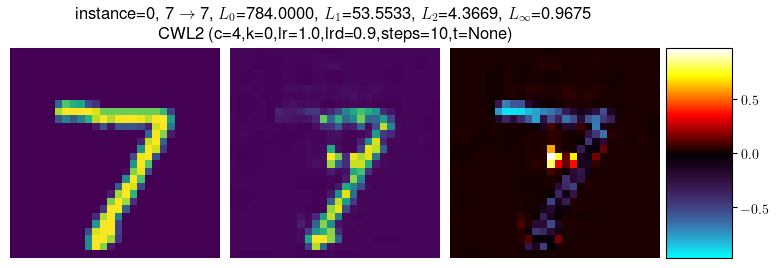

2: 2 -> 3 $L_0$=784.0000, $L_1$=42.5937, $L_2$=3.2318, $L_\infty$=0.8854


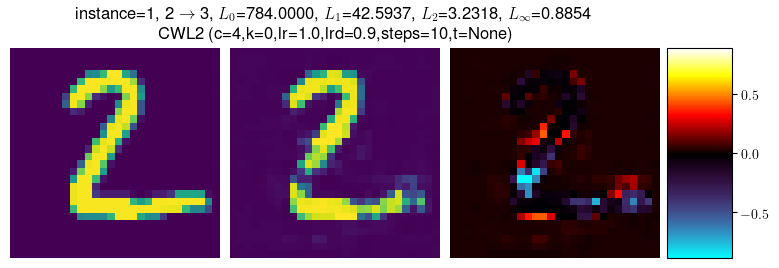

1: 1 -> 1 $L_0$=784.0000, $L_1$=40.0860, $L_2$=3.2752, $L_\infty$=0.7303


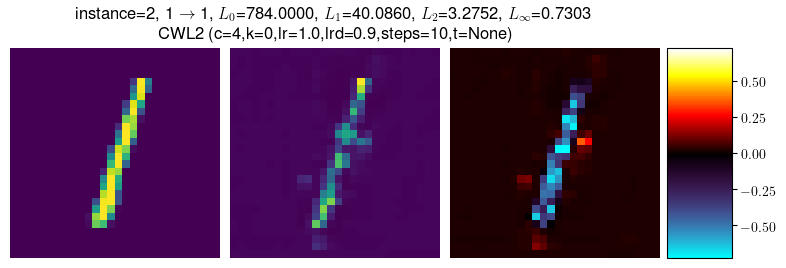

0: 0 -> 0 $L_0$=784.0000, $L_1$=45.1602, $L_2$=3.4745, $L_\infty$=0.9091


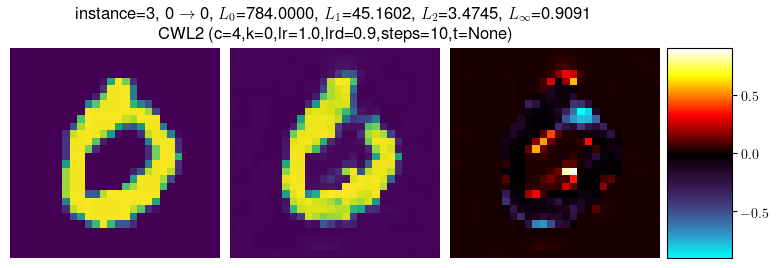

4: 4 -> 5 $L_0$=784.0000, $L_1$=37.2299, $L_2$=2.6594, $L_\infty$=0.7657


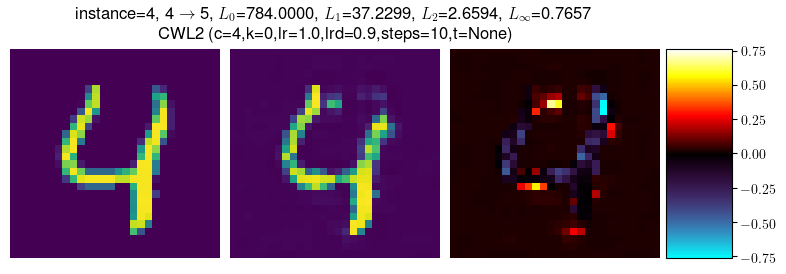

1: 1 -> 1 $L_0$=784.0000, $L_1$=42.4805, $L_2$=3.3713, $L_\infty$=0.8684


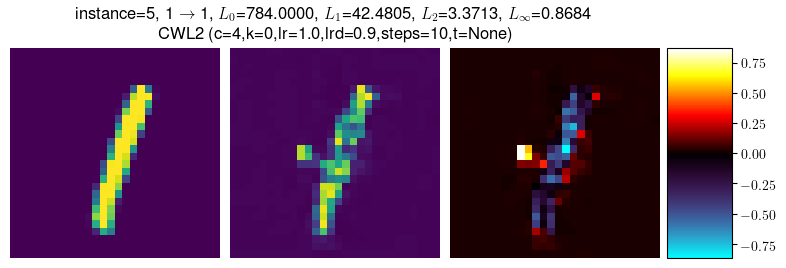

4: 4 -> 4 $L_0$=784.0000, $L_1$=31.4470, $L_2$=2.0693, $L_\infty$=0.7953


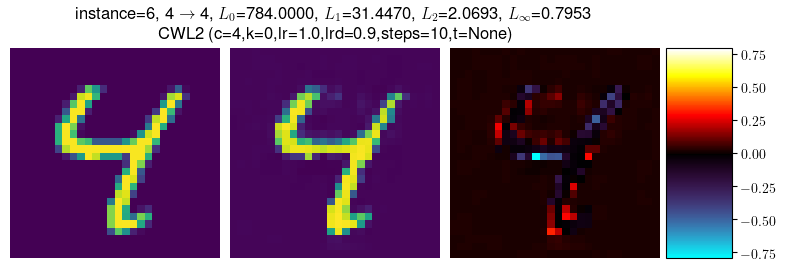

9: 2 -> 2 $L_0$=784.0000, $L_1$=17.4828, $L_2$=0.6457, $L_\infty$=0.0243


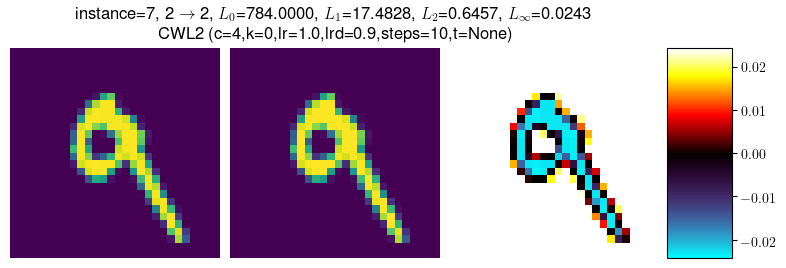

5: 5 -> 5 $L_0$=784.0000, $L_1$=50.1524, $L_2$=3.7298, $L_\infty$=0.8127


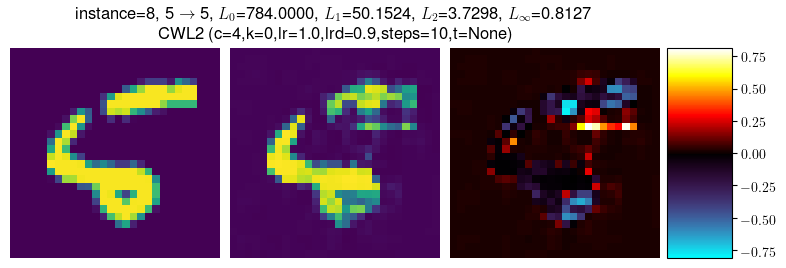

9: 7 -> 7 $L_0$=783.0000, $L_1$=17.0338, $L_2$=0.6359, $L_\infty$=0.0243


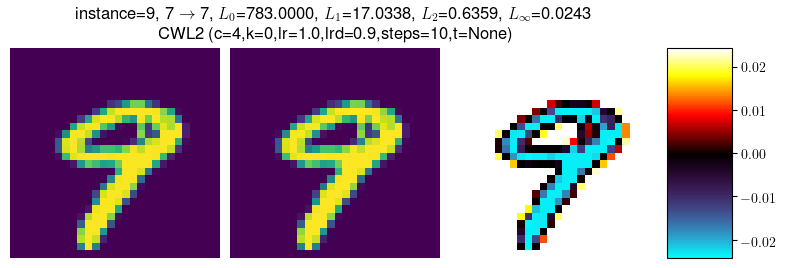

0: 0 -> 5 $L_0$=784.0000, $L_1$=55.2583, $L_2$=4.5988, $L_\infty$=0.9515


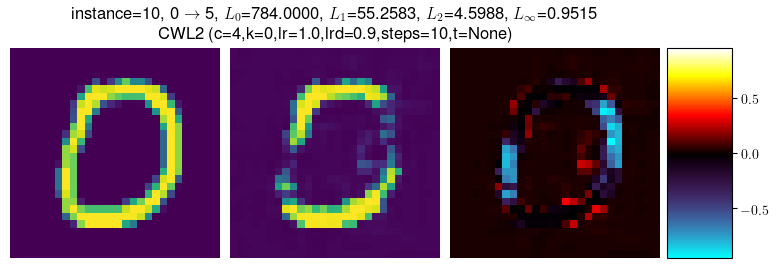

6: 6 -> 0 $L_0$=784.0000, $L_1$=30.1258, $L_2$=1.8475, $L_\infty$=0.5124


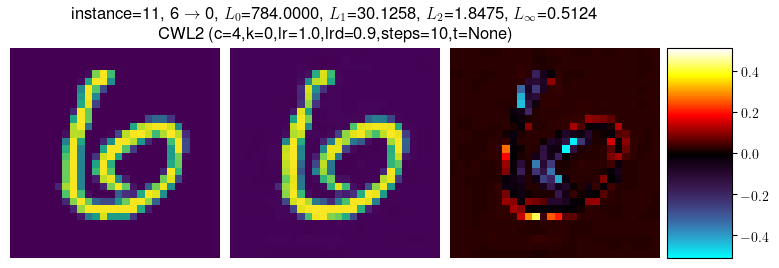

9: 9 -> 7 $L_0$=784.0000, $L_1$=26.3570, $L_2$=1.9150, $L_\infty$=0.7926


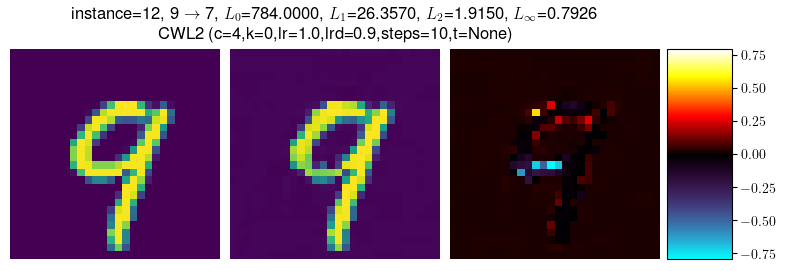

0: 0 -> 9 $L_0$=784.0000, $L_1$=56.1821, $L_2$=4.3079, $L_\infty$=0.9529


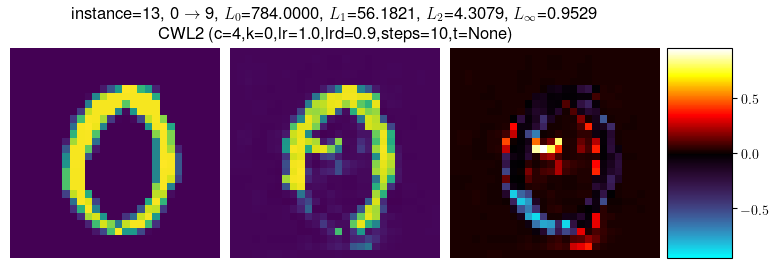

1: 1 -> 1 $L_0$=784.0000, $L_1$=39.7713, $L_2$=3.1272, $L_\infty$=0.8933


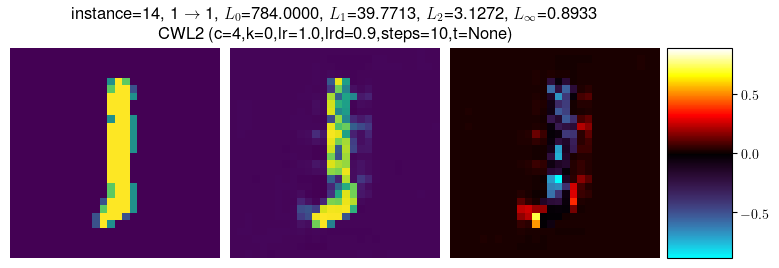

5: 5 -> 3 $L_0$=784.0000, $L_1$=21.5781, $L_2$=1.1746, $L_\infty$=0.4333


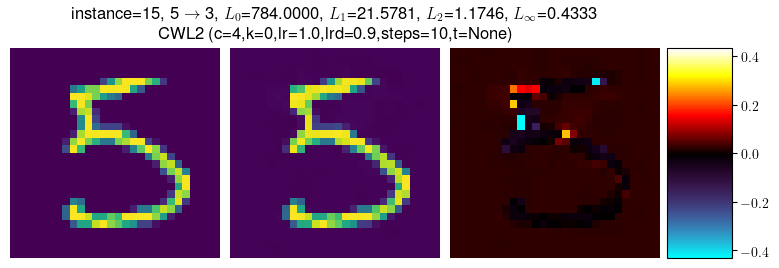

In [13]:
print("Original Attack")
show_attack(att, np.arange(0, 16), mnist_data.test)

Original Attack
7: 7 -> 7 $L_0$=784.0000, $L_1$=51.3744, $L_2$=4.2052, $L_\infty$=0.9439


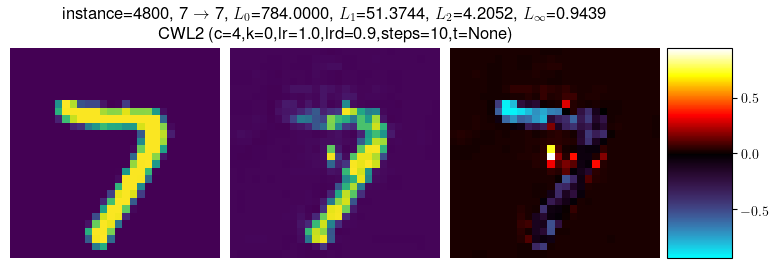

2: 2 -> 1 $L_0$=784.0000, $L_1$=38.2283, $L_2$=3.1172, $L_\infty$=0.9085


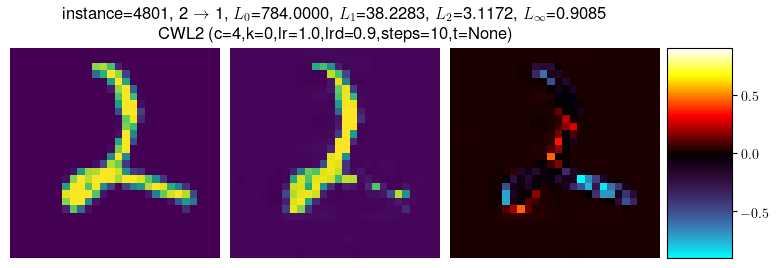

3: 3 -> 5 $L_0$=784.0000, $L_1$=37.0348, $L_2$=2.8691, $L_\infty$=0.7698


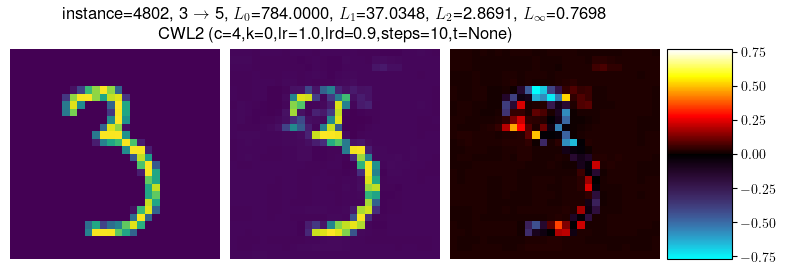

4: 4 -> 5 $L_0$=784.0000, $L_1$=29.9170, $L_2$=2.1246, $L_\infty$=0.8480


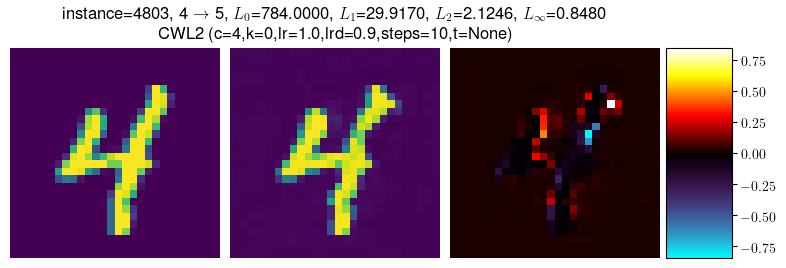

0: 0 -> 0 $L_0$=784.0000, $L_1$=48.0850, $L_2$=3.3186, $L_\infty$=0.6983


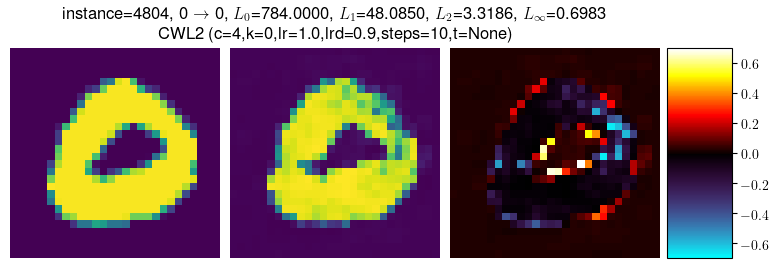

2: 2 -> 2 $L_0$=784.0000, $L_1$=44.4863, $L_2$=3.3880, $L_\infty$=0.8060


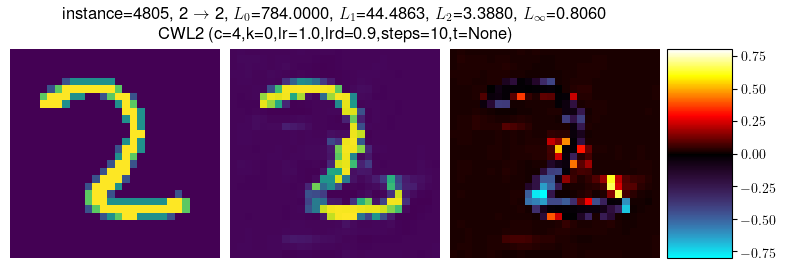

1: 1 -> 1 $L_0$=784.0000, $L_1$=46.4755, $L_2$=3.8013, $L_\infty$=0.8666


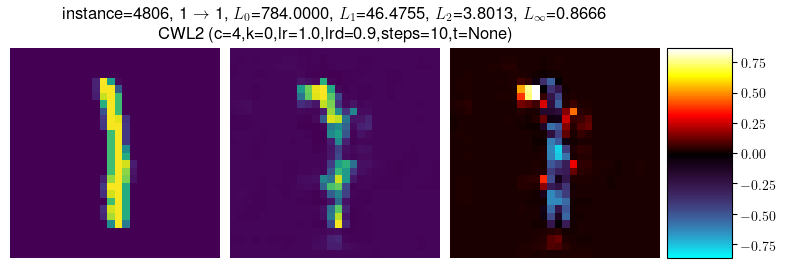

8: 0 -> 0 $L_0$=784.0000, $L_1$=16.9867, $L_2$=0.6361, $L_\infty$=0.0243


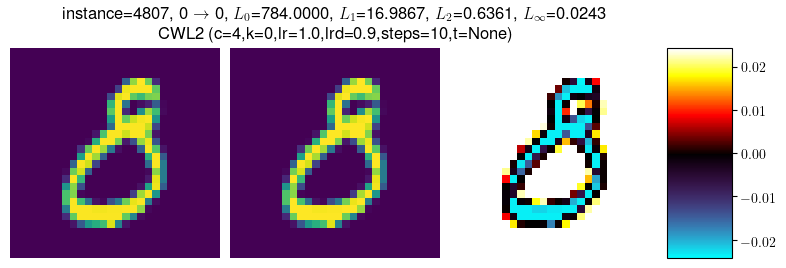

3: 3 -> 5 $L_0$=784.0000, $L_1$=22.3939, $L_2$=1.2654, $L_\infty$=0.5163


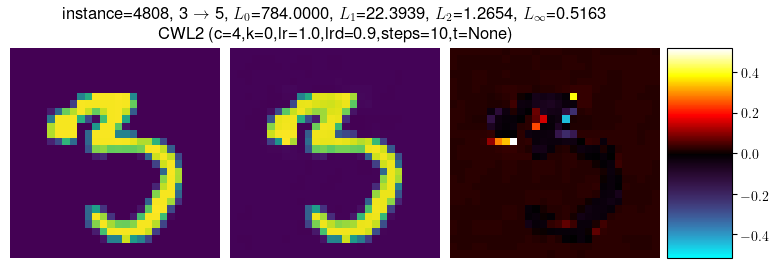

5: 5 -> 5 $L_0$=784.0000, $L_1$=58.2060, $L_2$=4.0414, $L_\infty$=0.9706


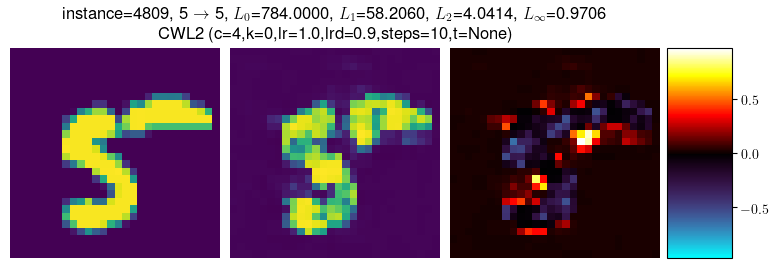

5: 5 -> 5 $L_0$=784.0000, $L_1$=42.8691, $L_2$=3.5596, $L_\infty$=0.8880


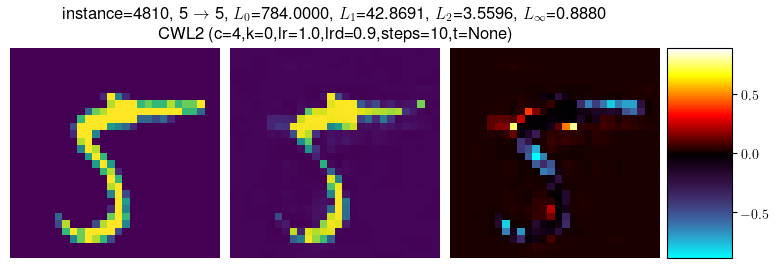

7: 7 -> 7 $L_0$=784.0000, $L_1$=50.2794, $L_2$=3.8032, $L_\infty$=0.9170


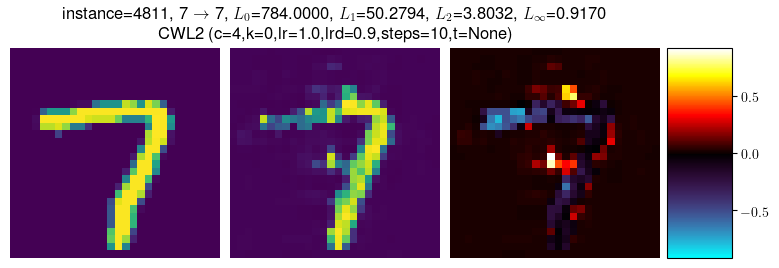

2: 2 -> 1 $L_0$=784.0000, $L_1$=30.1031, $L_2$=2.0769, $L_\infty$=0.7901


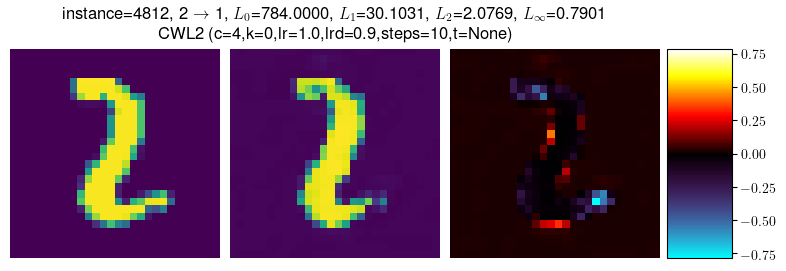

4: 4 -> 5 $L_0$=784.0000, $L_1$=26.6475, $L_2$=1.6694, $L_\infty$=0.5952


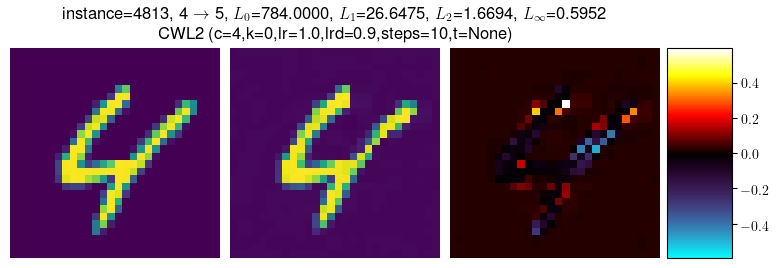

6: 0 -> 0 $L_0$=778.0000, $L_1$=16.7221, $L_2$=0.6301, $L_\infty$=0.0243


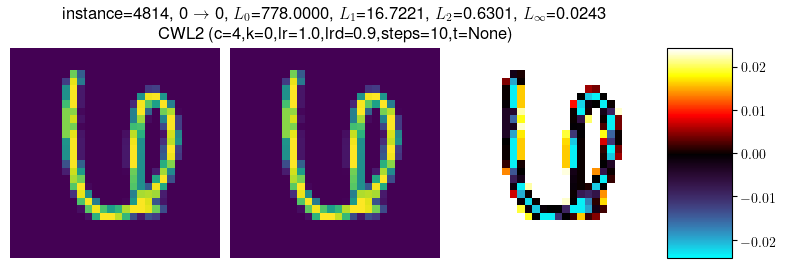

7: 7 -> 5 $L_0$=784.0000, $L_1$=44.5965, $L_2$=3.3500, $L_\infty$=0.8448


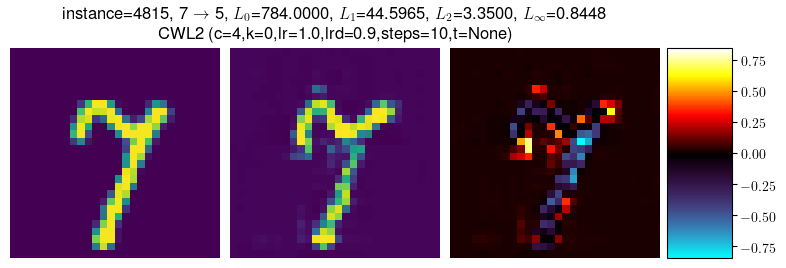

In [20]:
print("Original Attack")
show_attack(att, np.arange(4800, 4816), mnist_data.test)


Attack Sample 1:
7: 7 -> 7 $L_0$=784.0000, $L_1$=53.5533, $L_2$=4.3669, $L_\infty$=0.9675


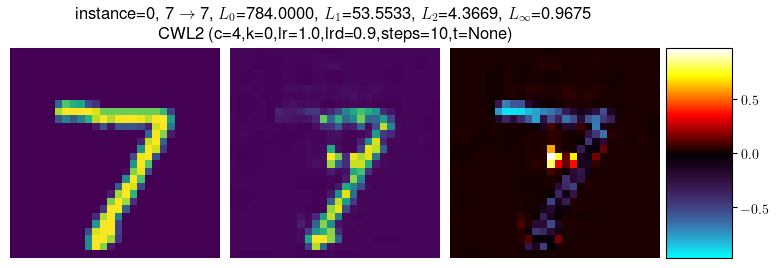

2: 2 -> 3 $L_0$=784.0000, $L_1$=42.5937, $L_2$=3.2318, $L_\infty$=0.8854


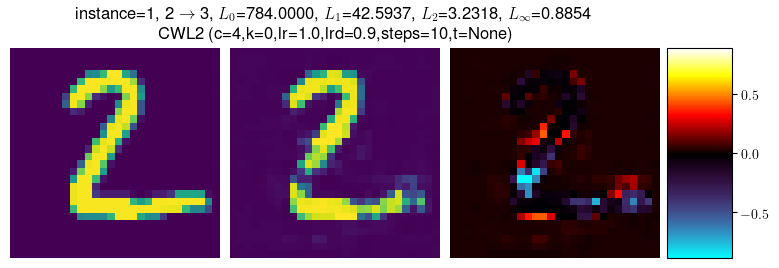

1: 1 -> 1 $L_0$=784.0000, $L_1$=40.0860, $L_2$=3.2752, $L_\infty$=0.7303


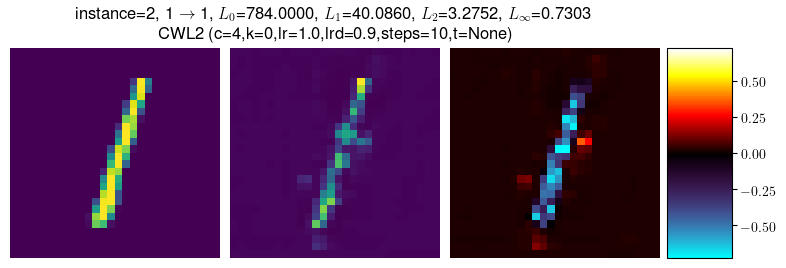

0: 0 -> 0 $L_0$=784.0000, $L_1$=45.1602, $L_2$=3.4745, $L_\infty$=0.9091


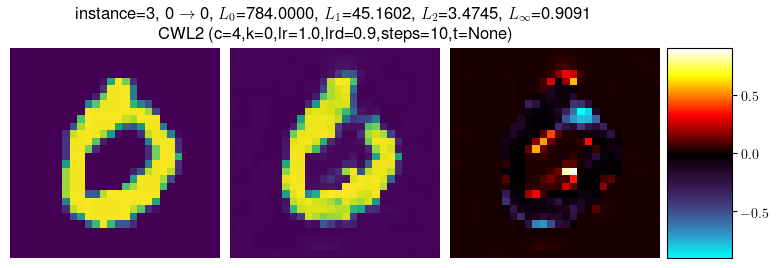

4: 4 -> 5 $L_0$=784.0000, $L_1$=37.2299, $L_2$=2.6594, $L_\infty$=0.7657


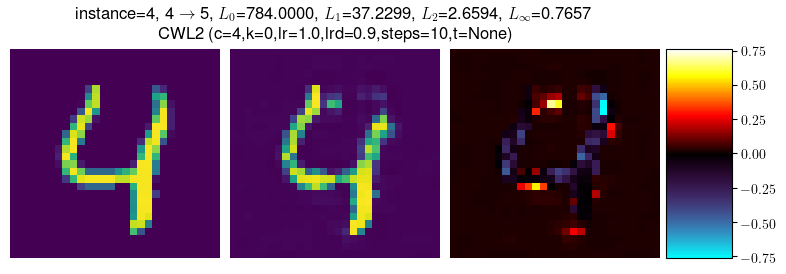

1: 1 -> 1 $L_0$=784.0000, $L_1$=42.4805, $L_2$=3.3713, $L_\infty$=0.8684


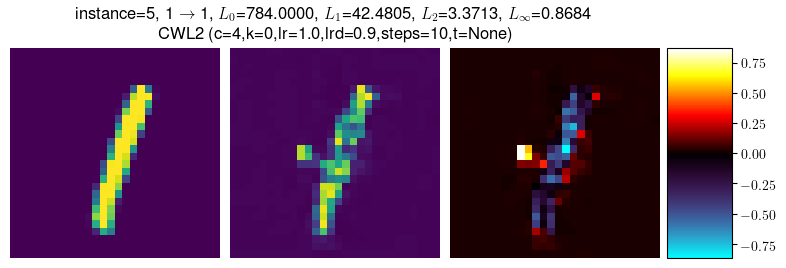

4: 4 -> 4 $L_0$=784.0000, $L_1$=31.4470, $L_2$=2.0693, $L_\infty$=0.7953


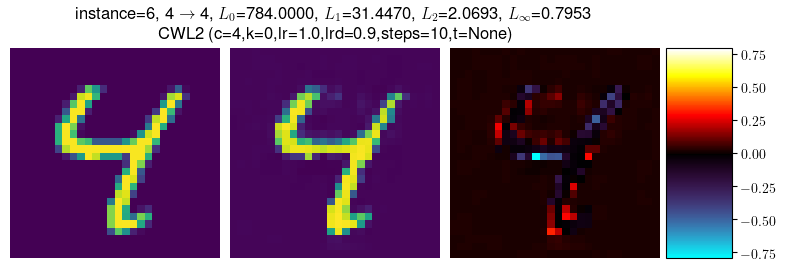

9: 2 -> 2 $L_0$=784.0000, $L_1$=17.4828, $L_2$=0.6457, $L_\infty$=0.0243


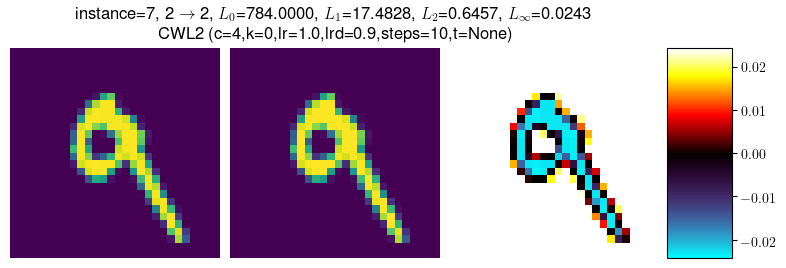

5: 5 -> 5 $L_0$=784.0000, $L_1$=50.1524, $L_2$=3.7298, $L_\infty$=0.8127


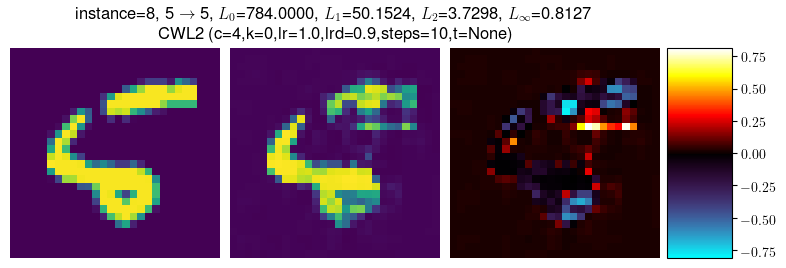

9: 7 -> 7 $L_0$=783.0000, $L_1$=17.0338, $L_2$=0.6359, $L_\infty$=0.0243


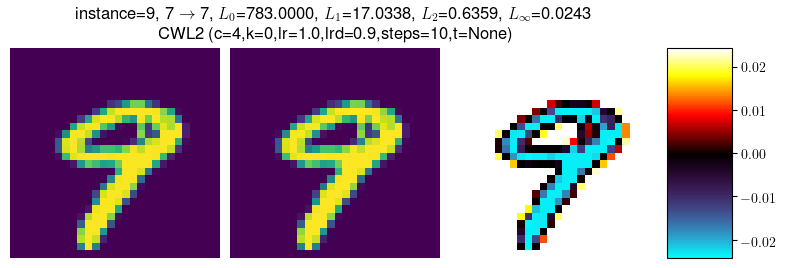

0: 0 -> 5 $L_0$=784.0000, $L_1$=55.2583, $L_2$=4.5988, $L_\infty$=0.9515


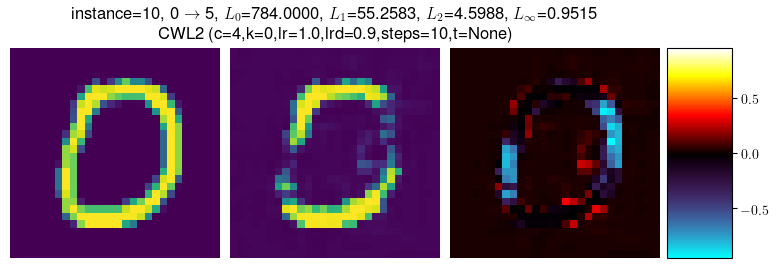

6: 6 -> 0 $L_0$=784.0000, $L_1$=30.1258, $L_2$=1.8475, $L_\infty$=0.5124


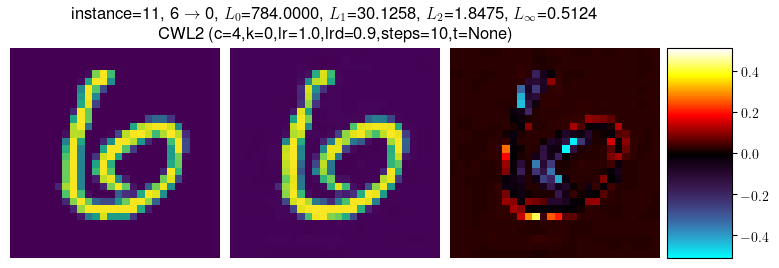

9: 9 -> 7 $L_0$=784.0000, $L_1$=26.3570, $L_2$=1.9150, $L_\infty$=0.7926


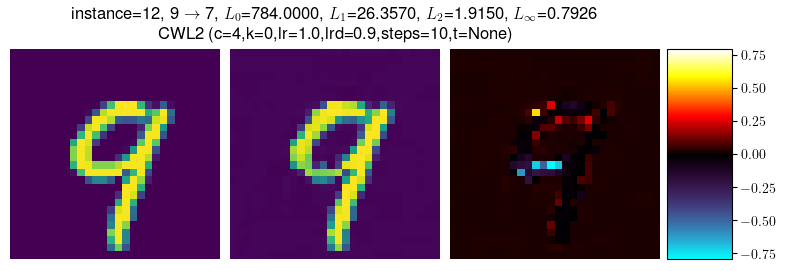

0: 0 -> 9 $L_0$=784.0000, $L_1$=56.1821, $L_2$=4.3079, $L_\infty$=0.9529


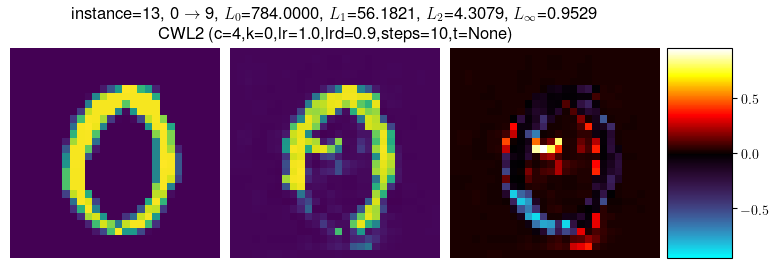

1: 1 -> 1 $L_0$=784.0000, $L_1$=39.7713, $L_2$=3.1272, $L_\infty$=0.8933


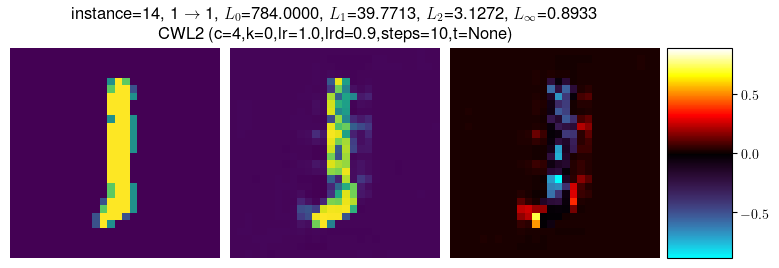

5: 5 -> 3 $L_0$=784.0000, $L_1$=21.5781, $L_2$=1.1746, $L_\infty$=0.4333


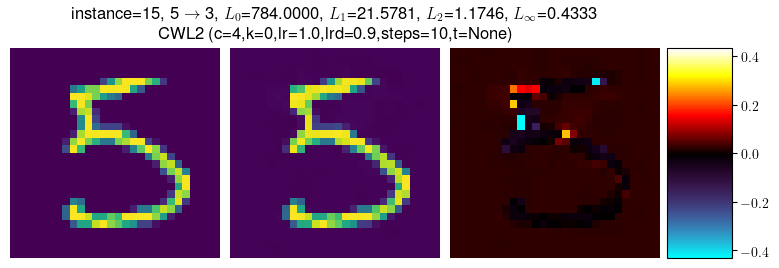

In [19]:
print("\nAttack Sample 1:")
show_attack(att2, np.arange(0,16), mnist_data.test)


Attack Sample 2:
7: 7 -> 7 $L_0$=784.0000, $L_1$=51.3744, $L_2$=4.2052, $L_\infty$=0.9439


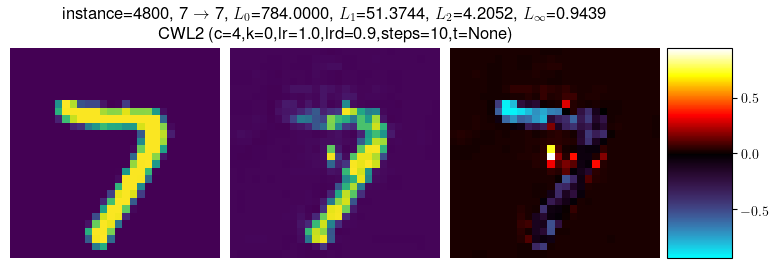

2: 2 -> 1 $L_0$=784.0000, $L_1$=38.2283, $L_2$=3.1172, $L_\infty$=0.9085


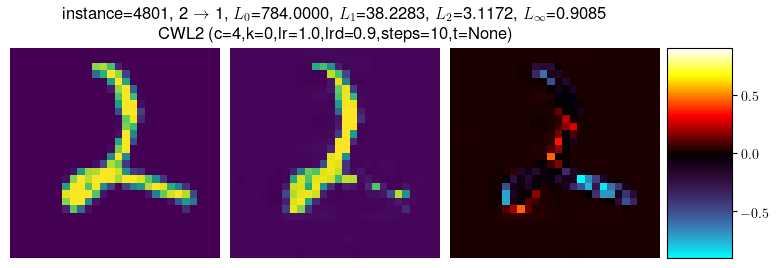

3: 3 -> 5 $L_0$=784.0000, $L_1$=37.0348, $L_2$=2.8691, $L_\infty$=0.7698


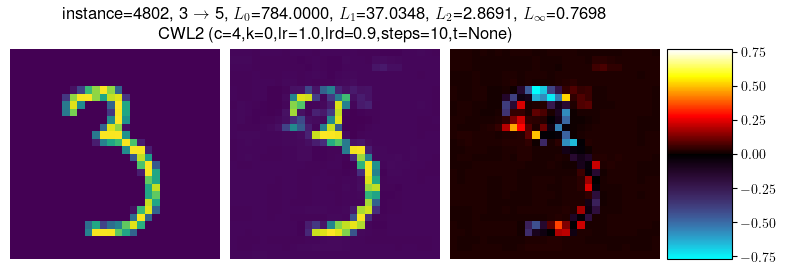

4: 4 -> 5 $L_0$=784.0000, $L_1$=29.9170, $L_2$=2.1246, $L_\infty$=0.8480


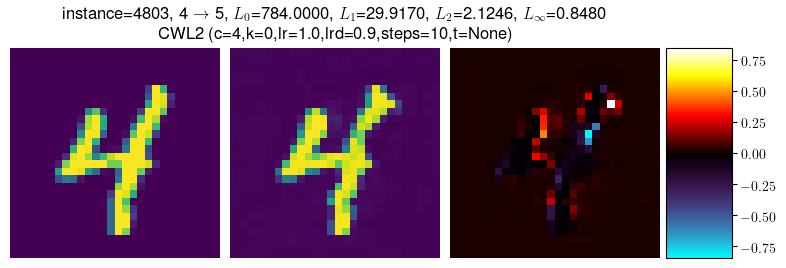

0: 0 -> 0 $L_0$=784.0000, $L_1$=48.0850, $L_2$=3.3186, $L_\infty$=0.6983


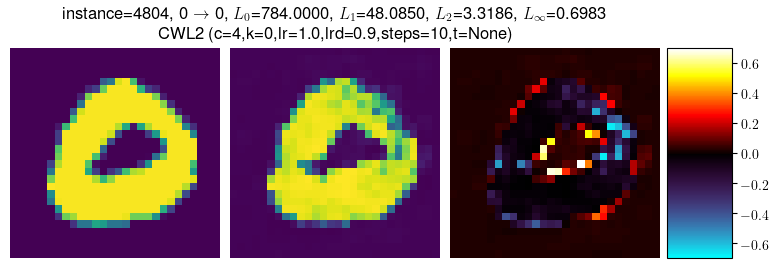

2: 2 -> 2 $L_0$=784.0000, $L_1$=44.4863, $L_2$=3.3880, $L_\infty$=0.8060


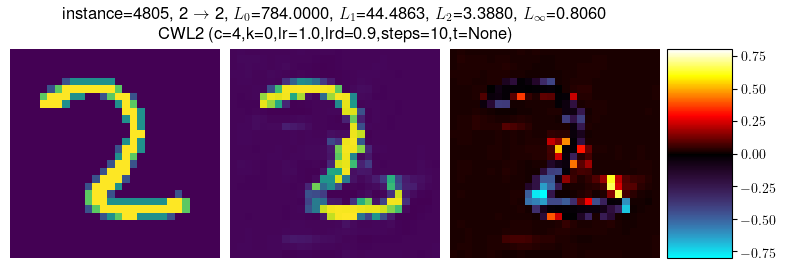

1: 1 -> 1 $L_0$=784.0000, $L_1$=46.4755, $L_2$=3.8013, $L_\infty$=0.8666


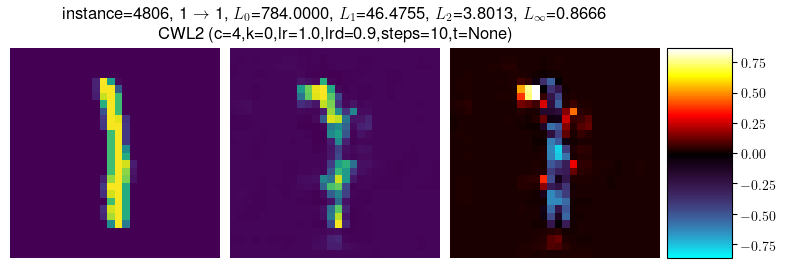

8: 0 -> 0 $L_0$=784.0000, $L_1$=16.9867, $L_2$=0.6361, $L_\infty$=0.0243


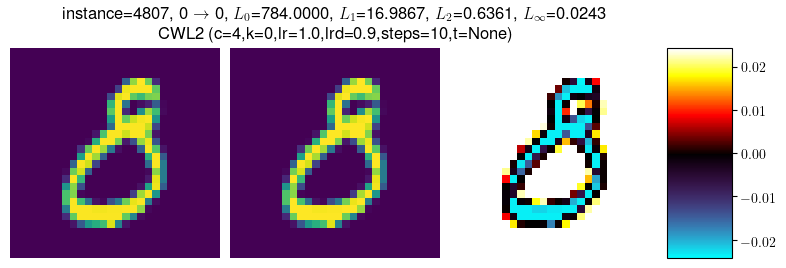

3: 3 -> 5 $L_0$=784.0000, $L_1$=22.3939, $L_2$=1.2654, $L_\infty$=0.5163


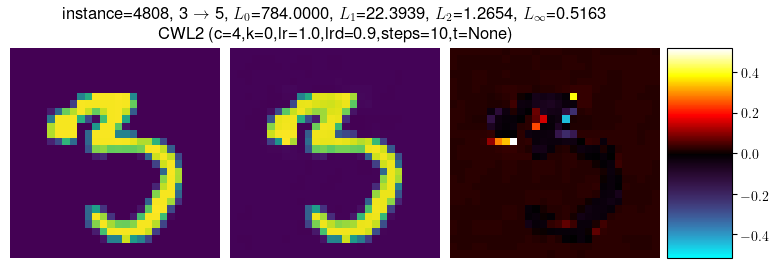

5: 5 -> 5 $L_0$=784.0000, $L_1$=58.2060, $L_2$=4.0414, $L_\infty$=0.9706


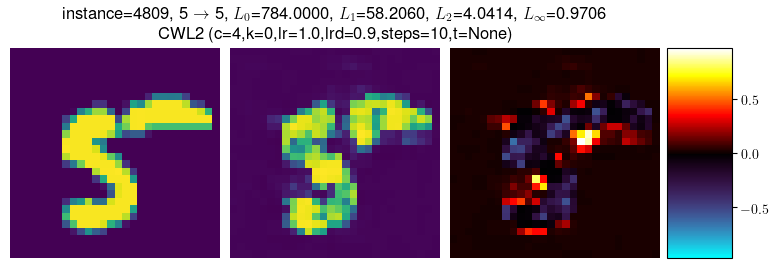

5: 5 -> 5 $L_0$=784.0000, $L_1$=42.8691, $L_2$=3.5596, $L_\infty$=0.8880


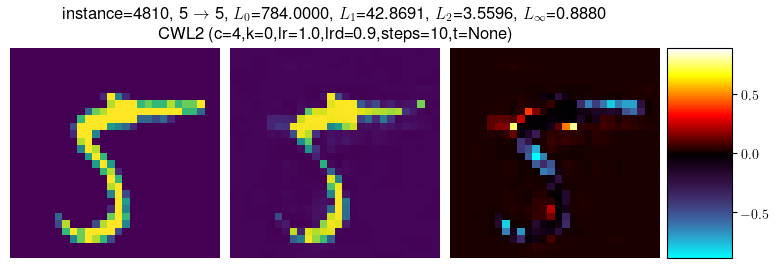

7: 7 -> 7 $L_0$=784.0000, $L_1$=50.2794, $L_2$=3.8032, $L_\infty$=0.9170


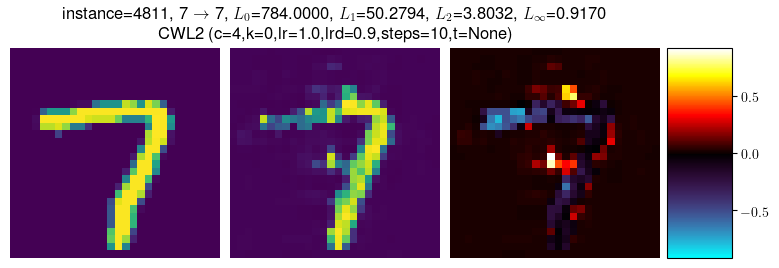

2: 2 -> 1 $L_0$=784.0000, $L_1$=30.1031, $L_2$=2.0769, $L_\infty$=0.7901


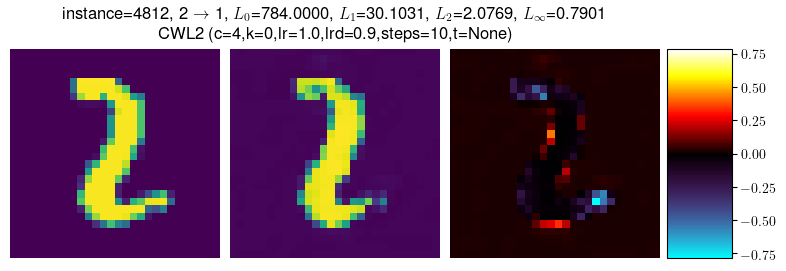

4: 4 -> 5 $L_0$=784.0000, $L_1$=26.6475, $L_2$=1.6694, $L_\infty$=0.5952


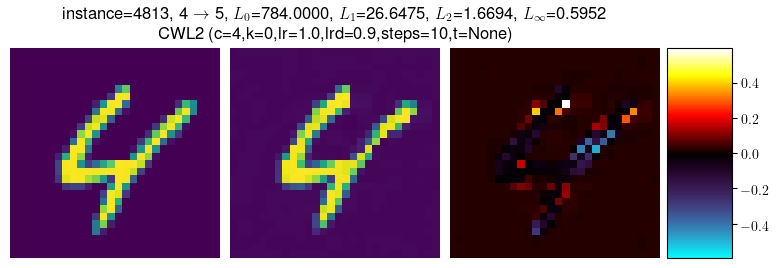

6: 0 -> 0 $L_0$=778.0000, $L_1$=16.7221, $L_2$=0.6301, $L_\infty$=0.0243


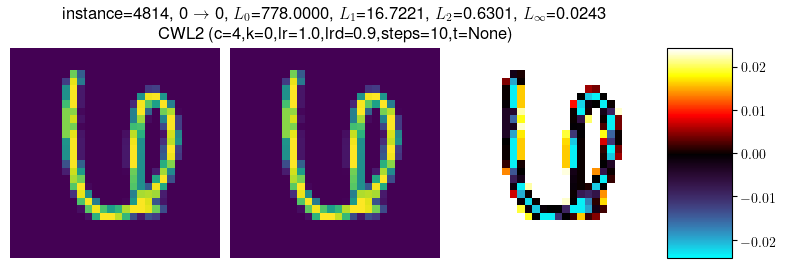

7: 7 -> 5 $L_0$=784.0000, $L_1$=44.5965, $L_2$=3.3500, $L_\infty$=0.8448


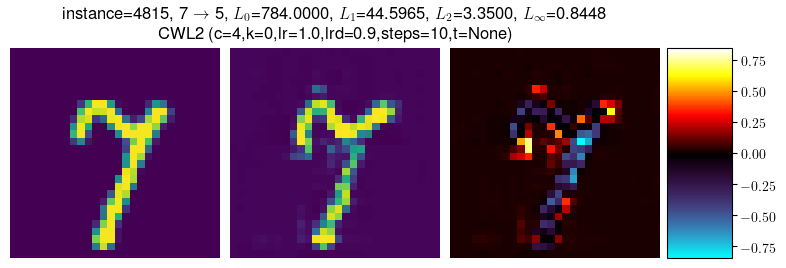

In [18]:

print("\nAttack Sample 2:")
show_attack(att2, np.arange(4800,4816), mnist_data.test)